In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

2022-05-25 11:28:43.138139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-25 11:28:43.138227: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_location = 'Data/train.csv'
train = pd.read_csv(data_location, index_col = 'Id')
test = pd.read_csv('Data/train.csv', index_col = 'Id')
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [3]:
train.shape

(1460, 80)

In [4]:
nan = train.isnull().sum()
missing_values = nan[nan > 0]
missing_values

to_remove = missing_values[missing_values > 600].index #any feature with more than 600 missing values is usless and imputation might throw off the model
train.drop(to_remove,axis = True,inplace = True)

Drop ``Alley``, ``PoolQC`` , ``Fence`` and ``MiscFeature`` and ``FireplaceQu`` as they have a heavy mjoriy of missing data and might throw off model

5 down, 65 to go

Next I will impute the rest of the missing data using the most frequent value from each column

In [5]:
from sklearn.impute import SimpleImputer

s = (train.dtypes == 'object')
object_cols = list(s[s].index)

train_imp = train.copy()

cat_imp = SimpleImputer(strategy='most_frequent')
train_imp[object_cols] = cat_imp.fit_transform(train[object_cols])

#train_imp.columns = train.columns
#train_imp.index.name = 'Id'

In [6]:
reg_imp = SimpleImputer()

reg_cols = train.drop(object_cols, axis=1).columns

train_imp[reg_cols] = reg_imp.fit_transform(train[reg_cols])

Next I will use Mutual information to try and detmin a smaller subset of features to use

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y):
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()
    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_regression(X,y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores



def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.axvline(scores.describe()['50%'], color = 'k') # tentative cutoff line of the lower 50%
    plt.title("Mutual Information Scores")


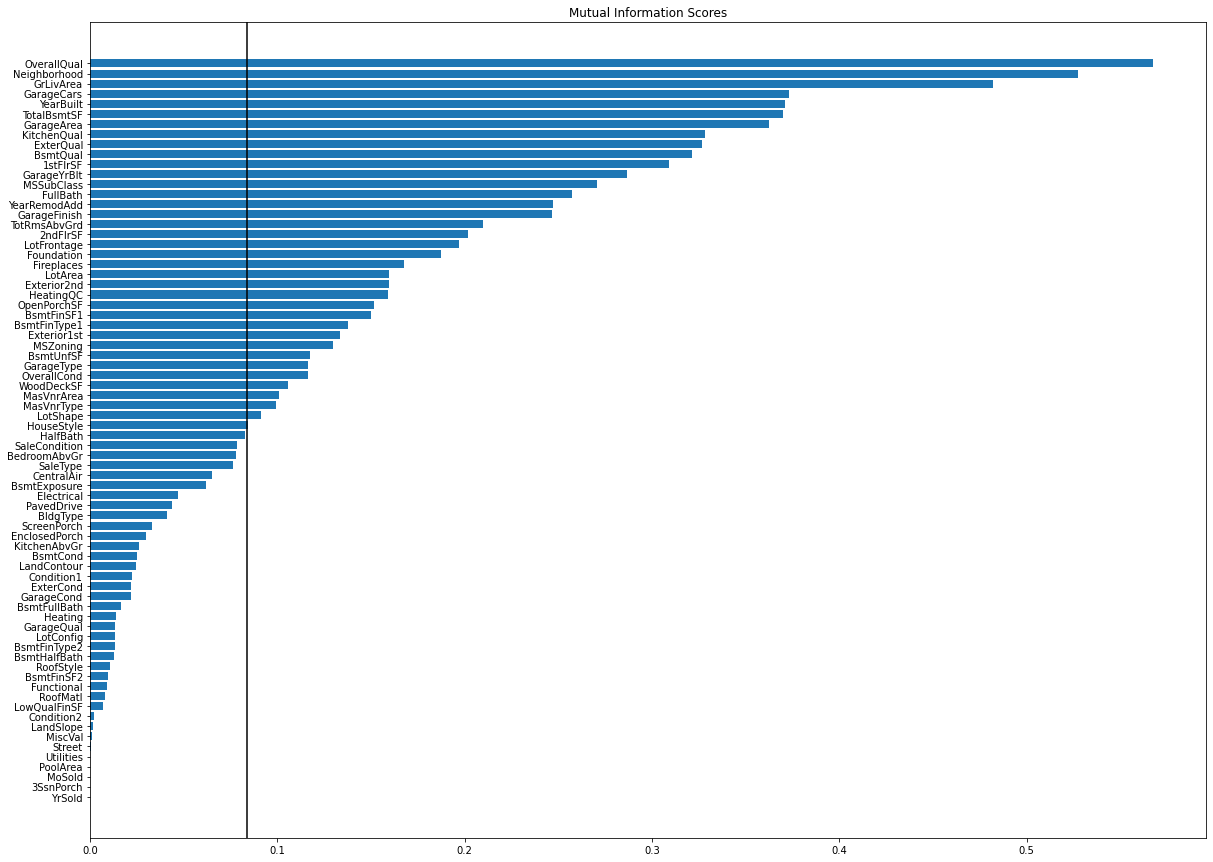

In [8]:
X = train_imp.drop('SalePrice',axis =1)
y = train_imp['SalePrice']
MI_score = make_mi_scores(X,y)
plt.figure(figsize=(20,15))
plot_mi_scores(MI_score)


With the exception of a few outliers near the bottom of the chart such as the ``2nd floor`` space this chart seems to represent the things that buyers typiclly look for most in a house, such as the top features being about the overall qualit of the property and the quality of the heating system. I will tentitivly determin that I will include any score

In [9]:
to_drop = MI_score[MI_score < MI_score.describe()['50%']].index
train_drop = train_imp.drop(to_drop, axis =1 )

In [10]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

s = (train_drop.dtypes == 'object')
object_cols = list(s[s].index)

train_corr = train_drop.copy()

train_corr[object_cols] = encoder.fit_transform(train_drop[object_cols])

# train_encoded.index = train_drop.index
# train_encoded.index.name = 'Id'


In [11]:
train_drop['BsmtQual']

Id
1       Gd
2       Gd
3       Gd
4       TA
5       Gd
        ..
1456    Gd
1457    Gd
1458    TA
1459    TA
1460    TA
Name: BsmtQual, Length: 1460, dtype: object

<AxesSubplot:>

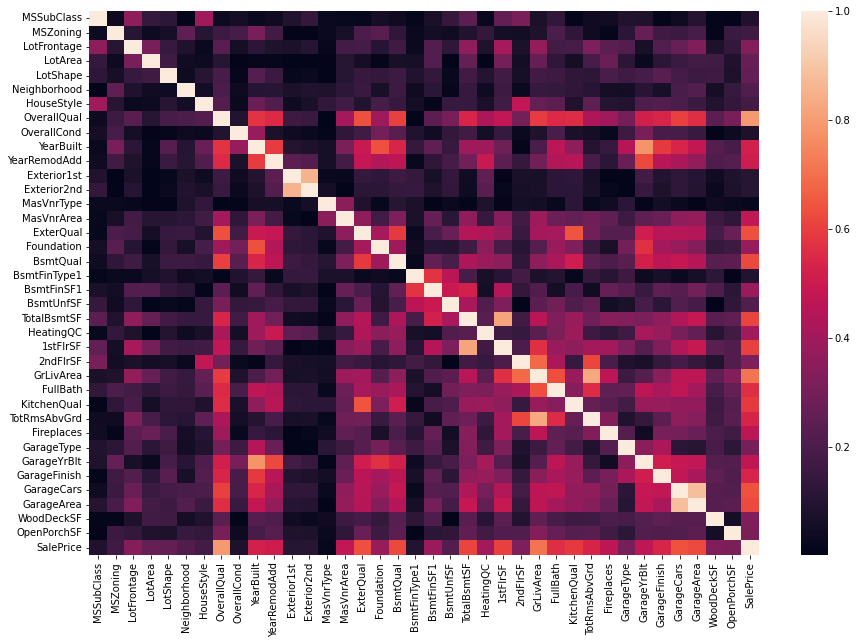

In [12]:
plt.figure(figsize = (15,10))
sns.heatmap(abs(train_corr.corr()))

This relatoinship makes sense as to house more cars you will need more area in th garage, may combine these into a single variable. Next I will look at the relationships between the grarage elements with respect to the sale price

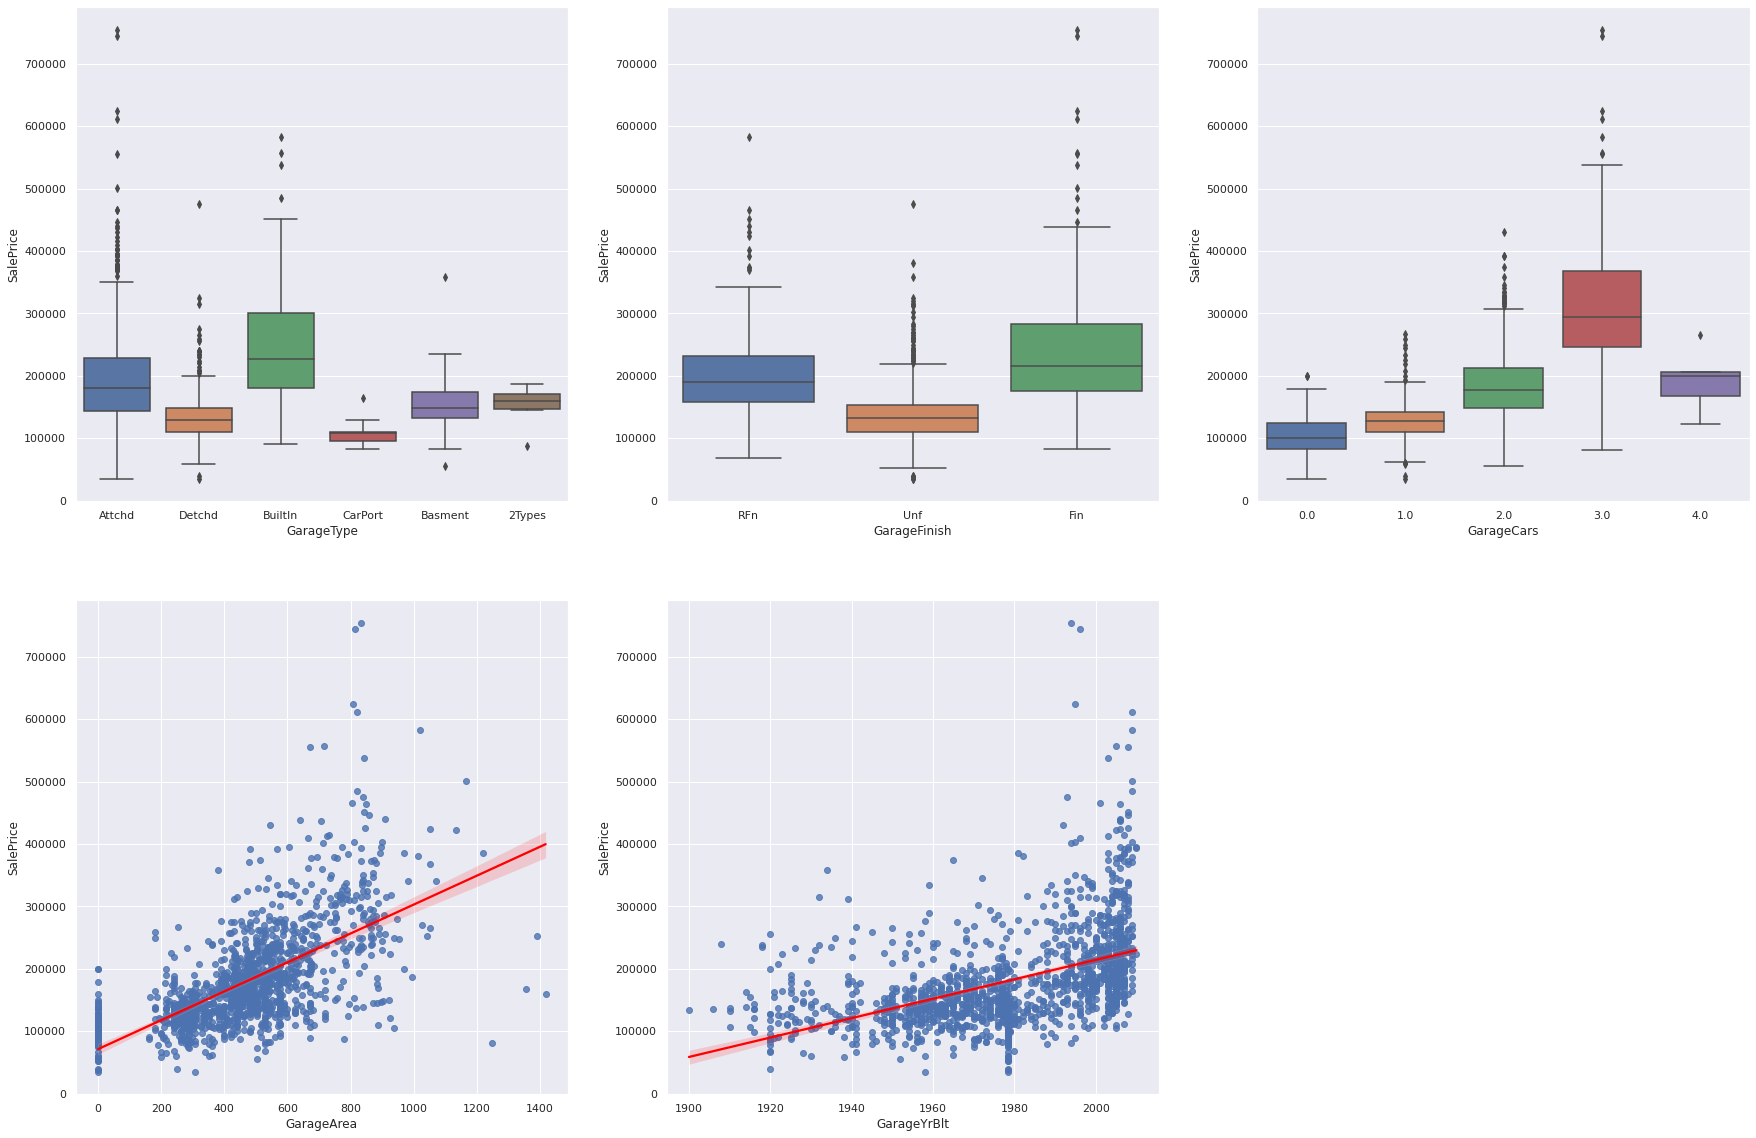

In [13]:
sns.set()
garage_ind = ['GarageType','GarageFinish', 'GarageCars', 'GarageArea', 'GarageYrBlt']

i=0
plt.figure(figsize = (30,20))
for _ in garage_ind:
    ax = plt.subplot(2,3 ,i+1)
    if i < 3:
        sns.boxplot(x = _, y = 'SalePrice', data = train_drop, ax=ax)
    else:
        sns.regplot(x = _, y = 'SalePrice',data = train_drop,line_kws={'color':'red'} ,ax = ax)
    
    i+=1

It appears as though the Built in Garages sell for the most in general, however there is alot of overlap, unlike a garage that can take 3 cars has clear seperation from the rest of the other number of cars.

The scatter plot of the garag area shows strong positive correlation to the price, where as the year, while having a positive correlation appears to the more exponential However the density is hard to see from this plot. I will do a rolling mean to show to try and get a better understanding of te trends

/tmp/ipykernel_110477/4102813470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_fit_year.sort_values('GarageArea',inplace = True)
/tmp/ipykernel_110477/4102813470.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_fit_year.sort_values('GarageYrBlt',inplace = True)


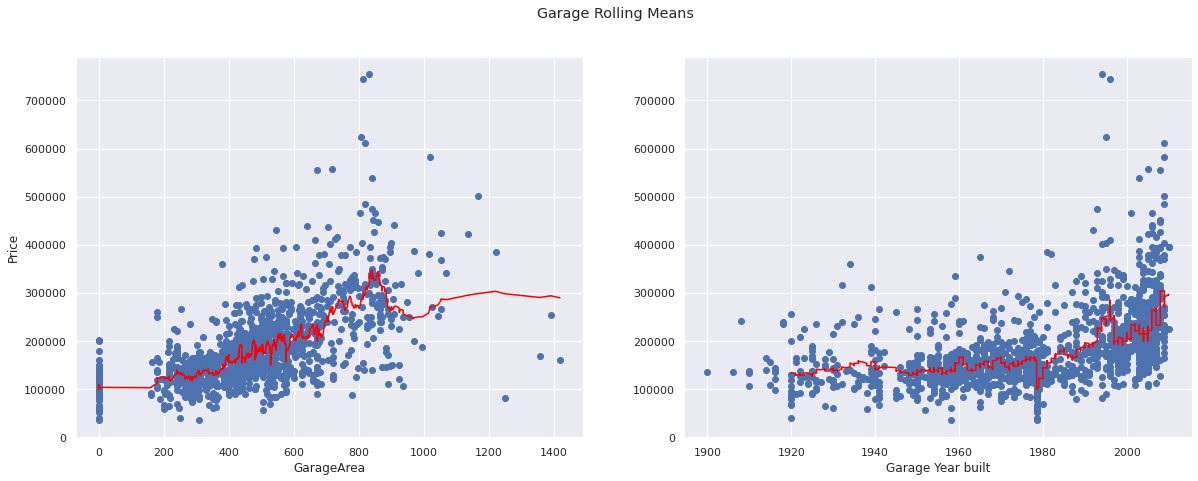

In [239]:
plt.figure(figsize = (20,7))
plt.suptitle('Garage Rolling Means')

for i in range(2):
    ax = plt.subplot(1,2 ,i+1)
    if i < 1:
        to_fit_year = train_drop[['SalePrice','GarageArea']]
        to_fit_year.sort_values('GarageArea',inplace = True)
        to_fit_year.set_index('GarageArea',inplace = True)

        plt.plot(to_fit_year.rolling(30).mean(), color = 'red')
        plt.scatter(train_drop['GarageArea'], train_drop['SalePrice'])
        plt.xlabel('GarageArea')
        plt.ylabel('Price')
    else:

        to_fit_year = train_drop[['SalePrice','GarageYrBlt']]
        to_fit_year.sort_values('GarageYrBlt',inplace = True)
        to_fit_year.set_index('GarageYrBlt',inplace = True)

        plt.plot(to_fit_year.rolling(30).mean(), color = 'red')
        plt.scatter(train_drop['GarageYrBlt'], train_drop['SalePrice'])
        plt.xlabel('Garage Year built')

In [278]:
from sklearn.linear_model import LinearRegression
to_use = ['OverallQual']
X = train_corr[to_use]


model = LinearRegression()

model.fit(X, train_corr['SalePrice'])

LinearRegression()

In [279]:
pred = pd.Series(model.predict(X))
pred.index.name = 'Id'

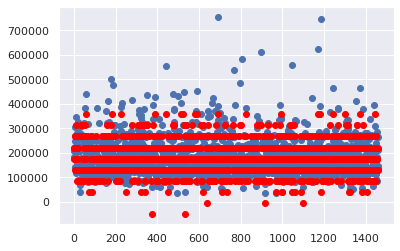

In [280]:
plt.scatter(train_corr.index, train_corr['SalePrice'])
plt.scatter(pred.index, pred, color = 'red')

In [281]:
log_rmse = np.sqrt(np.mean((np.log(pred) - np.log(train_corr['SalePrice']))**2))

/home/bernardhollands/envs/tensor/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [282]:
log_rmse

0.5474403832636175

In [267]:
log_rmse

0.5309615021105661

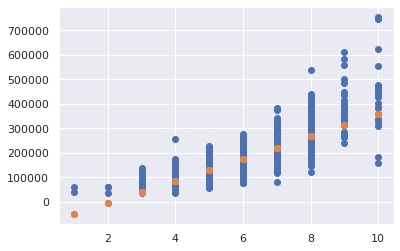

In [286]:
plt.scatter(X,train_corr['SalePrice'] )
plt.scatter(X,pred)